In [1]:
import torch
import utilities

device = ("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [2]:
data_main = utilities.pre_processing_base(
    csv="../data/SIDI_Full.csv",
    device=device,
    split=0.8,
    target_var="DI",
)

In [3]:
data_main[100]

(array([  4.,   1., -15.,  15.], dtype=float32), 0.40649)

In [4]:
data_ft = utilities.pre_processing_ft(data_main, device)
data_t = utilities.pre_processing_t(data_main, device)
data_f = utilities.pre_processing_f(data_main, device)
data_none = utilities.pre_processing_none(data_main, device)

In [5]:
losses = {
    "data_none": [],
    "data_ft": [],
    "data_f": [],
    "data_t": [],
}

overall_scores = {
    "data_none": [],
    "data_ft": [],
    "data_f": [],
    "data_t": [],
}

In [6]:
import math
import rtdl
import delu

config = {
    "learning_rate": 0.0003,
    "epochs": 1000,
    "batch_size": 32,
    "dropout": 0.2,
    "train_split": 0.8,
    "weight_decay": 0.0,
    "patience": 20
}

data = data_f
model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    target = data.y[part]
    score = loss_fn(pred, target)
    return {
        "score": score,
        "pred": pred,
        "target": target
    }

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test")["score"]:.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score['score'].cpu().numpy())
    test_rmse = math.sqrt(test_score['score'].cpu().numpy())

    losses['data_f'].append(test_rmse)
    overall_scores['data_f'].append(test_score)

    print(f'Epoch {epoch:03d} | Validation score: {val_score["score"]:.4f} | Test score: {test_score["score"]:.4f}', end='')
    progress.update((-1) * val_score["score"])
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break


/home/color/miniconda3/envs/hvis_rtdl/lib/python3.10/site-packages/delu/_utils.py:14: DeLUDeprecationWarning: The function make_index_dataloader` is deprecated and will be removed in future releases. Instead, use `delu.data.IndexDataset` and `~torch.utils.data.DataLoader`
  warnings.warn(


Test score before training: 0.1538
Epoch 000 | Validation score: 0.0738 | Test score: 0.0661 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.0508 | Test score: 0.0463 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.0326 | Test score: 0.0314 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.0191 | Test score: 0.0200 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.0126 | Test score: 0.0144 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 0.0093 | Test score: 0.0110 <<< BEST VALIDATION EPOCH
Epoch 006 | Validation score: 0.0077 | Test score: 0.0097 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 0.0061 | Test score: 0.0078 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.0051 | Test score: 0.0063 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.0043 | Test score: 0.0055 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.0039 | Test score: 0.0052 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation score: 0.0034 | Te

In [7]:
data = data_t
model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    target = data.y[part]
    score = loss_fn(pred, target)
    return {
        "score": score,
        "pred": pred,
        "target": target
    }

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test")["score"]:.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score['score'].cpu().numpy())
    test_rmse = math.sqrt(test_score['score'].cpu().numpy())

    losses['data_t'].append(test_rmse)
    overall_scores['data_t'].append(test_score)

    print(f'Epoch {epoch:03d} | Validation score: {val_score["score"]:.4f} | Test score: {test_score["score"]:.4f}', end='')
    progress.update((-1) * val_score["score"])
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

Test score before training: 2.9431
Epoch 000 | Validation score: 0.8002 | Test score: 0.7981 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.7925 | Test score: 0.8094 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.9086 | Test score: 0.8872
Epoch 003 | Validation score: 0.8605 | Test score: 0.8517
Epoch 004 | Validation score: 0.8307 | Test score: 0.7953
Epoch 005 | Validation score: 0.8391 | Test score: 0.8193
Epoch 006 | Validation score: 0.8630 | Test score: 0.8175
Epoch 007 | Validation score: 0.8637 | Test score: 0.8161
Epoch 008 | Validation score: 0.8800 | Test score: 0.8171
Epoch 009 | Validation score: 0.8517 | Test score: 0.7902
Epoch 010 | Validation score: 0.8473 | Test score: 0.7821
Epoch 011 | Validation score: 0.8570 | Test score: 0.7839
Epoch 012 | Validation score: 0.8363 | Test score: 0.7657
Epoch 013 | Validation score: 0.8520 | Test score: 0.7693
Epoch 014 | Validation score: 0.8427 | Test score: 0.7657
Epoch 015 | Validation score: 0.8649 | Test

In [8]:
data = data_ft
model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    target = data.y[part]
    score = loss_fn(pred, target)
    return {
        "score": score,
        "pred": pred,
        "target": target
    }

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test")["score"]:.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score['score'].cpu().numpy())
    test_rmse = math.sqrt(test_score['score'].cpu().numpy())

    losses['data_ft'].append(test_rmse)
    overall_scores['data_ft'].append(test_score)

    print(f'Epoch {epoch:03d} | Validation score: {val_score["score"]:.4f} | Test score: {test_score["score"]:.4f}', end='')
    progress.update((-1) * val_score["score"])
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

Test score before training: 0.8815
Epoch 000 | Validation score: 0.9097 | Test score: 0.7882 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.7954 | Test score: 0.6971 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.6376 | Test score: 0.5688 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.4416 | Test score: 0.4076 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.2520 | Test score: 0.2502 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 0.1213 | Test score: 0.1407 <<< BEST VALIDATION EPOCH
Epoch 006 | Validation score: 0.0695 | Test score: 0.0939 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 0.0555 | Test score: 0.0786 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.0489 | Test score: 0.0709 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.0452 | Test score: 0.0659 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.0421 | Test score: 0.0625 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation score: 0.0398 | Te

In [9]:
data = data_none
model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    target = data.y[part]
    score = loss_fn(pred, target)
    return {
        "score": score,
        "pred": pred,
        "target": target
    }

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test")["score"]:.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score['score'].cpu().numpy())
    test_rmse = math.sqrt(test_score['score'].cpu().numpy())

    losses['data_none'].append(test_rmse)
    overall_scores['data_none'].append(test_score)

    print(f'Epoch {epoch:03d} | Validation score: {val_score["score"]:.4f} | Test score: {test_score["score"]:.4f}', end='')
    progress.update((-1) * val_score["score"])
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

Test score before training: 19.9209
Epoch 000 | Validation score: 1.2056 | Test score: 1.0083 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.3551 | Test score: 0.3682 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.5220 | Test score: 0.5183
Epoch 003 | Validation score: 0.2111 | Test score: 0.2048 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.2703 | Test score: 0.2608
Epoch 005 | Validation score: 0.2278 | Test score: 0.2189
Epoch 006 | Validation score: 0.1943 | Test score: 0.1901 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 0.1858 | Test score: 0.1841 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.1879 | Test score: 0.1845
Epoch 009 | Validation score: 0.1717 | Test score: 0.1793 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.1527 | Test score: 0.1608 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation score: 0.1586 | Test score: 0.1678
Epoch 012 | Validation score: 0.1580 | Test score: 0.1741
Epoch 013 | Validation score

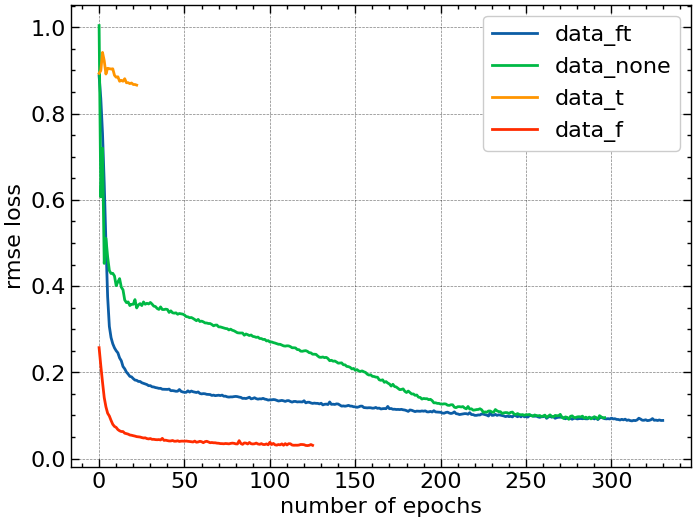

In [10]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
# plt.style.use(['default'])
plt.plot(losses['data_ft'], label='data_ft')
plt.plot(losses['data_none'], label='data_none')
plt.plot(losses['data_t'], label='data_t')
plt.plot(losses['data_f'], label='data_f')
plt.xlabel('number of epochs')
plt.ylabel('rmse loss')
plt.legend()
plt.savefig("../figures/pp_impact.pdf")
plt.show()


In [14]:
overall_scores['data_f']

[{'score': tensor(0.0661, device='cuda:0'),
  'pred': tensor([0.2197, 0.3970, 0.4184, 0.2930, 0.4142, 0.3076, 0.2406, 0.3691, 0.2762,
          0.2839, 0.3090, 0.1785, 0.2964, 0.3523, 0.3731, 0.3466, 0.3800, 0.4494,
          0.2066, 0.3369, 0.3399, 0.3342, 0.3510, 0.4289, 0.3305, 0.3592, 0.2419,
          0.1909, 0.3588, 0.4044, 0.4004, 0.4490, 0.2262, 0.2224, 0.3751, 0.4160,
          0.2422, 0.4154, 0.3427, 0.4276, 0.3574, 0.2855, 0.2642, 0.3899, 0.4468,
          0.2672, 0.3343, 0.3123, 0.1836, 0.3800, 0.3445, 0.4484, 0.3732, 0.2618,
          0.3467, 0.3364, 0.3729, 0.4068, 0.3180, 0.2469, 0.4931, 0.2757, 0.2705,
          0.3638, 0.3903, 0.3012, 0.2963, 0.4076, 0.3070, 0.4213, 0.1752, 0.3190,
          0.2941, 0.3515, 0.2906, 0.3012, 0.3465, 0.3535, 0.2926, 0.3573, 0.2903,
          0.4273, 0.1890, 0.2817, 0.3409, 0.3233, 0.3023, 0.2407, 0.2873, 0.3608,
          0.3280, 0.2900, 0.3323, 0.3392, 0.2580, 0.3167, 0.2504, 0.4444, 0.2811,
          0.2070, 0.2872, 0.3964, 0.2690, 0.39